# IF3070 Foundations of Artificial Intelligence | Tugas Besar 2

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: 07

Group Members:
- Bryan P. Hutagalung (18222130)
- Ardra Rafif Sahasika (18222134)
- Timothy Haposan Simanjuntak (18222137)
- Yusril Fazri Mahendra (18222141)

## Import Libraries

In [118]:
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import re
from itertools import groupby
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

## Import Dataset

In [119]:
# Load the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
pd.set_option('display.max_columns', None)

# Display the first few rows of the training set
train.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,1,NaN,https://www.northcm.ac.th,24.0,www.northcm.ac.th,17.0,0.0,NaN,0.800000,NaN,NaN,NaN,2.0,0.0,NaN,0.0,NaN,0.417,0.0,0.000,0.0,0.0,0.0,2.0,0.083,NaN,NaN,457.0,NaN,norhcmac,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,5.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0,NaN,3.0,NaN,69.0,NaN,NaN,1
1,4,8135291.txt,http://uqr.to/1il1z,NaN,NaN,NaN,NaN,to,1.000000,0.000896,0.036850,2.0,0.0,NaN,0.0,NaN,8.0,0.421,2.0,0.105,NaN,NaN,0.0,2.0,NaN,NaN,9.0,NaN,1.0,NaN,NaN,100.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0
2,5,586561.txt,https://www.woolworthsrewards.com.au,35.0,www.woolworthsrewards.com.au,28.0,0.0,au,0.857143,NaN,0.060894,NaN,2.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,woolworthsrewrdscom,0.0,0.0,1.0,0.0,1.0,NaN,1.0,NaN,0.0,3.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,33.0,7.0,8.0,15.0,NaN,2.0,1
3,6,NaN,NaN,31.0,NaN,NaN,NaN,com,0.562500,0.522907,0.055829,NaN,1.0,NaN,0.0,NaN,17.0,NaN,0.0,0.000,NaN,0.0,0.0,NaN,0.065,NaN,NaN,5062.0,NaN,NaN,100.0,100.0,NaN,0.0,NaN,0.0,0.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,24.0,5.0,14.0,NaN,NaN,NaN,1
4,11,412632.txt,NaN,NaN,www.nyprowrestling.com,22.0,0.0,NaN,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,0.000,NaN,0.0,NaN,1.0,0.034,1.0,766.0,NaN,NaN,nyprowrestling,100.0,100.0,1.0,1.0,NaN,0.0,NaN,1.0,0.0,0.0,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,14.0,NaN,0.0,NaN,1


In [120]:
for col in train.columns:
    print(col, train[col].value_counts())

id id
235795    1
1         1
4         1
5         1
235769    1
         ..
20        1
19        1
17        1
12        1
11        1
Name: count, Length: 140404, dtype: int64
FILENAME FILENAME
464776.txt     1
8135291.txt    1
586561.txt     1
412632.txt     1
899992.txt     1
              ..
639096.txt     1
732052.txt     1
475173.txt     1
542037.txt     1
775628.txt     1
Name: count, Length: 82872, dtype: int64
URL URL
http://www.strangled.net                                 2
https://bmsgadmin.com/admin/index.php                    2
http://test-mantenimiento-bancaweb.azurewebsites.net/    2
http://uqr.to/1il1z                                      1
https://www.woolworthsrewards.com.au                     1
                                                        ..
https://www.restaumatic.com                              1
https://www.sportscar2.com                               1
https://www.123telugu.com                                1
https://kg56rf-bur5g7.firebaseapp.c

## Constants

In [121]:
# Define the target feature
TARGET = 'Label'

# Define the numerical and categorical features
NUM_FEATS = train.select_dtypes(include=[np.number]).columns.tolist()
CAT_FEATS = train.select_dtypes(exclude=[np.number]).columns.tolist()

BOOL_FEATS = []
for COL in NUM_FEATS:
    UNIQUE_VALS = set(train[COL].dropna().unique())
    if UNIQUE_VALS.issubset({0, 1, 0.0, 1.0, True, False}) and 'NoOf' not in COL:
        BOOL_FEATS.append(COL)

NUM_FEATS = [col for col in NUM_FEATS if col not in BOOL_FEATS]
CAT_FEATS = CAT_FEATS + BOOL_FEATS

THEME = 'orangered'
CMAP_COLOUR = LinearSegmentedColormap.from_list(THEME, ['#FFECEC',THEME])

In [122]:
CAT_FEATS

['FILENAME',
 'URL',
 'Domain',
 'TLD',
 'Title',
 'IsDomainIP',
 'HasObfuscation',
 'IsHTTPS',
 'HasTitle',
 'HasFavicon',
 'Robots',
 'IsResponsive',
 'HasDescription',
 'HasExternalFormSubmit',
 'HasSocialNet',
 'HasSubmitButton',
 'HasHiddenFields',
 'HasPasswordField',
 'Bank',
 'Pay',
 'Crypto',
 'HasCopyrightInfo',
 'label']

In [123]:
NUM_FEATS

['id',
 'URLLength',
 'DomainLength',
 'CharContinuationRate',
 'TLDLegitimateProb',
 'URLCharProb',
 'TLDLength',
 'NoOfSubDomain',
 'NoOfObfuscatedChar',
 'ObfuscationRatio',
 'NoOfLettersInURL',
 'LetterRatioInURL',
 'NoOfDegitsInURL',
 'DegitRatioInURL',
 'NoOfEqualsInURL',
 'NoOfQMarkInURL',
 'NoOfAmpersandInURL',
 'NoOfOtherSpecialCharsInURL',
 'SpacialCharRatioInURL',
 'LineOfCode',
 'LargestLineLength',
 'DomainTitleMatchScore',
 'URLTitleMatchScore',
 'NoOfURLRedirect',
 'NoOfSelfRedirect',
 'NoOfPopup',
 'NoOfiFrame',
 'NoOfImage',
 'NoOfCSS',
 'NoOfJS',
 'NoOfSelfRef',
 'NoOfEmptyRef',
 'NoOfExternalRef']

In [124]:
train.columns

Index(['id', 'FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength',
       'IsDomainIP', 'TLD', 'CharContinuationRate', 'TLDLegitimateProb',
       'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation',
       'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL',
       'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL',
       'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
       'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS',
       'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title',
       'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots',
       'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription',
       'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet',
       'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
       'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
       'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label'],

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

In [125]:
train_set, val_set = train_test_split(train, test_size=0.3, random_state=42)
train_set.shape, val_set.shape

((98282, 56), (42122, 56))

# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

#### 1. Data Imputation

In [126]:
# Custom transformer for feature imputation
class FeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self, num_feats, cat_feats):
        self.num_feats = num_feats
        self.cat_feats = cat_feats

    def fit(self, X, y=None):
        self.fill_values = {}
        for column in X.columns:
            if column in self.cat_feats:
                self.fill_values[column] = X[column].mode().iloc[0]
            elif column in self.num_feats:
                self.fill_values[column] = X[column].mean()
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for column, value in self.fill_values.items():
            X[column] = X[column].fillna(value)
        return X

#### 2. Deletion of Missing Data

#### 3. Domain-Specific Strategies

#### 4. Imputation Libraries

### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

In [127]:
# Remove outliers using the IQR method for numerical features
Q1 = train_set[NUM_FEATS].quantile(0.25)
Q3 = train_set[NUM_FEATS].quantile(0.75)
IQR = Q3 - Q1
train_set = train_set[~((train_set[NUM_FEATS] < (Q1 - 1.5 * IQR)) | (train_set[NUM_FEATS] > (Q3 + 1.5 * IQR))).any(axis=1)]

### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [128]:
# Remove duplicate rows
train_set.drop_duplicates(inplace=True)
val_set.drop_duplicates(inplace=True)

### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

In [129]:
def merge_and_cluster(X_train, X_test, n_clusters=3, random_state=None):
    """
    Merge X_train and X_test, apply K-means clustering, and return train and test sets with cluster labels.

    Parameters:
        - X_train: DataFrame containing training data.
        - X_test: DataFrame containing test data.
        - n_clusters: Number of clusters for K-means clustering.
        - random_state: Random seed for reproducibility.

    Returns:
        - X_train_clustered: Training data with cluster labels.
        - X_test_clustered: Test data with cluster labels.
    """
    # Merge X_train and X_test
    combined_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    combined_data['cluster_label'] = kmeans.fit_predict(combined_data)

    # Split the data back into train and test sets with cluster labels
    X_train_clustered, X_test_clustered = train_test_split(
        combined_data, test_size=len(X_test), random_state=random_state, shuffle=False
    )

    return X_train_clustered, X_test_clustered

In [130]:
# Custom transformer for feature creation
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Fill missing Domain with part of URL starting from www
        X['Domain'] = X.apply(lambda row: row['URL'].split('//')[-1].split('/')[0] if pd.isnull(row['Domain']) and pd.notnull(row['URL']) else row['Domain'], axis=1)
        # Fill missing URL with https:// followed by Domain
        X['URL'] = X.apply(lambda row: 'https://' + row['Domain'] if pd.isnull(row['URL']) and pd.notnull(row['Domain']) else row['URL'], axis=1)

        # Extract Title from URL
        X['Title'] = X['URL'].apply(lambda x: re.search(r'//(www\.)?([^/]+)', str(x)).group(2) if pd.notnull(x) else '')

        X['URLLength'] = X['URL'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
        X['DomainLength'] = X['Domain'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
        X['TitleLength'] = X['Title'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
        X['TLD'] = X['Domain'].apply(lambda x: x.split('.')[-1] if pd.notnull(x) else '')
        X['TLDLength'] = X['TLD'].apply(lambda x: len(x))
        X['NoOfLettersInURL'] = X['URL'].apply(lambda x: len(re.findall(r'[a-zA-Z]', str(x))) if pd.notnull(x) else 0)
        X['NoOfDigitsInURL'] = X['URL'].apply(lambda x: len(re.findall(r'\d', str(x))) if pd.notnull(x) else 0)
        X['NoOfEqualsInURL'] = X['URL'].apply(lambda x: str(x).count('=') if pd.notnull(x) else 0)
        X['NoOfQMarkInURL'] = X['URL'].apply(lambda x: str(x).count('?') if pd.notnull(x) else 0)
        X['NoOfAmpersandInURL'] = X['URL'].apply(lambda x: str(x).count('&') if pd.notnull(x) else 0)
        X['NoOfOtherSpecialCharsInURL'] = X['URL'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9=&?]', str(x))) if pd.notnull(x) else 0)
        X['LetterRatioInURL'] = X.apply(lambda row: row['NoOfLettersInURL'] / row['URLLength'] if row['URLLength'] > 0 else 0, axis=1)
        X['SpecialCharRatioInURL'] = X.apply(lambda row: (row['NoOfEqualsInURL'] + row['NoOfQMarkInURL'] + row['NoOfAmpersandInURL'] + row['NoOfOtherSpecialCharsInURL']) / row['URLLength'] if row['URLLength'] > 0 else 0, axis=1)
        X['DigitRatioInURL'] = X.apply(lambda row: row['NoOfDigitsInURL'] / row['URLLength'] if row['URLLength'] > 0 else 0, axis=1)
        X['DomainRatioInURL'] = X.apply(lambda row: row['DomainLength'] / row['URLLength'] if row['URLLength'] > 0 else 0, axis=1)
        X['TLDRatioInURL'] = X.apply(lambda row: row['TLDLength'] / row['URLLength'] if row['URLLength'] > 0 else 0, axis=1)
        X['IsHTTPS'] = X['URL'].apply(lambda x: 1 if str(x).startswith('https') else 0)
        X['DomainTitleMatchScore'] = X.apply(lambda row: sum(1 for char in str(row['Domain']) if char in str(row['Title'])) / len(str(row['Domain'])) if pd.notnull(row['Domain']) and pd.notnull(row['Title']) and len(row['Domain']) > 0 else 0, axis=1)
        X['URLTitleMatchScore'] = X.apply(lambda row: sum(1 for char in str(row['URL']) if char in str(row['Title'])) / len(str(row['URL'])) if pd.notnull(row['URL']) and pd.notnull(row['Title']) and len(row['URL']) > 0 else 0, axis=1)
        X['CharContinuationRate'] = X['URL'].apply(lambda x: np.mean([len(list(g)) for k, g in groupby(str(x)) if k.isalpha()]) if pd.notnull(x) else 0)
        X['HasObfuscation'] = X['URL'].apply(lambda x: 1 if re.search(r'%[0-9a-fA-F]{2}', str(x)) else 0)
        X['IsDomainIP'] = X['Domain'].apply(lambda x: 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', str(x)) else 0)
        X['NoOfObfuscatedChar'] = X['URL'].apply(lambda x: len(re.findall(r'%[0-9a-fA-F]{2}', str(x))) if pd.notnull(x) else 0)
        X['NoOfSubDomain'] = X['Domain'].apply(lambda x: len(str(x).split('.')) - 2 if pd.notnull(x) else 0)
        X['ObfuscationCharRatioInURL'] = X.apply(lambda row: row['NoOfObfuscatedChar'] / row['URLLength'] if row['URLLength'] > 0 else 0, axis=1)
        X['Label'] = X['label']


        return X

In [131]:
# Custom transformer for feature dropping
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_feats, cat_feats):
        self.columns_to_drop = ['id', 'FILENAME', 'URL', 'Domain', 'TLD',
                                'Title', 'NoOfLettersInURL', 'NoOfDigitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
                                'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'HasObfuscation',
                                'SpacialCharRatioInURL', 'DegitRatioInURL', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'TLDLength',
                                'DomainLength', 'NoOfDegitsInURL', 'label', 'IsDomainIP']
        self.num_feats = num_feats
        self.cat_feats = cat_feats

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Drop rows where URL, Title, and Domain are all NaN
        X = X.dropna(subset=['URL', 'TLD', 'Domain', 'Title', 'URLLength', 'TLDLength', 'DomainLength', 'TitleLength'], how='all')
        # Drop specified columns
        columns_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        X.drop(columns=columns_to_drop, inplace=True)
        self.num_feats = [col for col in self.num_feats if col not in self.columns_to_drop]
        self.cat_feats = [col for col in self.cat_feats if col not in self.columns_to_drop]

        return X

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

In [132]:
# Custom transformer for feature downcasting
class FeatureDowncaster(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for col in X.select_dtypes(include=['float64']).columns:
            X[col] = pd.to_numeric(X[col], downcast='float')
        for col in X.select_dtypes(include=['int64']).columns:
            X[col] = pd.to_numeric(X[col], downcast='integer')
        return X

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

In [133]:
# Custom transformer for feature scaling
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, num_feats):
        self.num_feats = num_feats

    def fit(self, X, y=None):
        # Fit the scaler to the numerical columns that exist in the DataFrame
        self.existing_num_feats = [col for col in self.num_feats if col in X.columns]
        self.sc = StandardScaler().fit(X[self.existing_num_feats])
        return self

    def transform(self, X):
        # Scale the numerical columns that exist in the DataFrame
        X = X.copy()
        if self.existing_num_feats:
            X[self.existing_num_feats] = self.sc.transform(X[self.existing_num_feats])
        return X

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

In [134]:
# Custom transformer for feature encoding
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_feats):
        self.cat_feat = cat_feats

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_encoded = X.copy()

        for col in self.cat_feat:
            if col not in X.columns:
                continue  # Skip to the next iteration if the column does not exist
            
            # Process the column if it exists
            if X[col].nunique() == 2:
                # Map the column with a dictionary
                X_encoded[col] = X_encoded[col].map({'Yes': 1, 'No': 0})
            else:
                # Perform one-hot encoding
                X_encoded = pd.concat([X_encoded, pd.get_dummies(X_encoded[col], prefix=col)], axis=1)
                # Drop original categorical columns from DataFrame
                X_encoded.drop(col, axis=1, inplace=True)

        return X_encoded

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [135]:
# Create the pipeline
pipe1 = Pipeline([
    ("imputer", FeatureImputer(NUM_FEATS, CAT_FEATS)),
    ("creator", FeatureCreator())
    
])

# Fit and transform the training set
train_set = pipe1.fit_transform(train_set)
val_set = pipe1.transform(val_set)

C:\Users\Bryan Hutagalung\AppData\Roaming\Python\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [136]:
val_set.isna().sum()

id                           0
FILENAME                     0
URL                          0
URLLength                    0
Domain                       0
                            ..
DigitRatioInURL              0
DomainRatioInURL             0
TLDRatioInURL                0
ObfuscationCharRatioInURL    0
Label                        0
Length: 64, dtype: int64

In [137]:
# Create the pipeline
pipe2 = Pipeline([
    ("dropper", FeatureDropper(NUM_FEATS, CAT_FEATS))
    
])

# Fit and transform the training set
train_set = pipe2.fit_transform(train_set)
val_set = pipe2.transform(val_set)

C:\Users\Bryan Hutagalung\AppData\Roaming\Python\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [138]:
train_set.columns

Index(['URLLength', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb',
       'NoOfSubDomain', 'LetterRatioInURL', 'IsHTTPS', 'LineOfCode',
       'LargestLineLength', 'HasTitle', 'HasFavicon', 'Robots', 'IsResponsive',
       'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup',
       'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet',
       'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
       'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
       'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'TitleLength',
       'SpecialCharRatioInURL', 'DigitRatioInURL', 'DomainRatioInURL',
       'TLDRatioInURL', 'ObfuscationCharRatioInURL', 'Label'],
      dtype='object')

1. Correlation Matrix between Features:
                           URLLength  CharContinuationRate  TLDLegitimateProb  \
URLLength                   1.000000             -0.579724           0.152118   
CharContinuationRate       -0.579724              1.000000          -0.077083   
TLDLegitimateProb           0.152118             -0.077083           1.000000   
URLCharProb                 0.035140             -0.019360           0.158699   
NoOfSubDomain               0.059002             -0.006152          -0.116801   
LetterRatioInURL            0.918766             -0.643428           0.193460   
IsHTTPS                    -0.208152              0.777755           0.005538   
LineOfCode                  0.004956             -0.000136           0.007821   
LargestLineLength           0.050468             -0.017252           0.029198   
HasTitle                    0.011189             -0.005863           0.002255   
HasFavicon                 -0.025870              0.012478          -

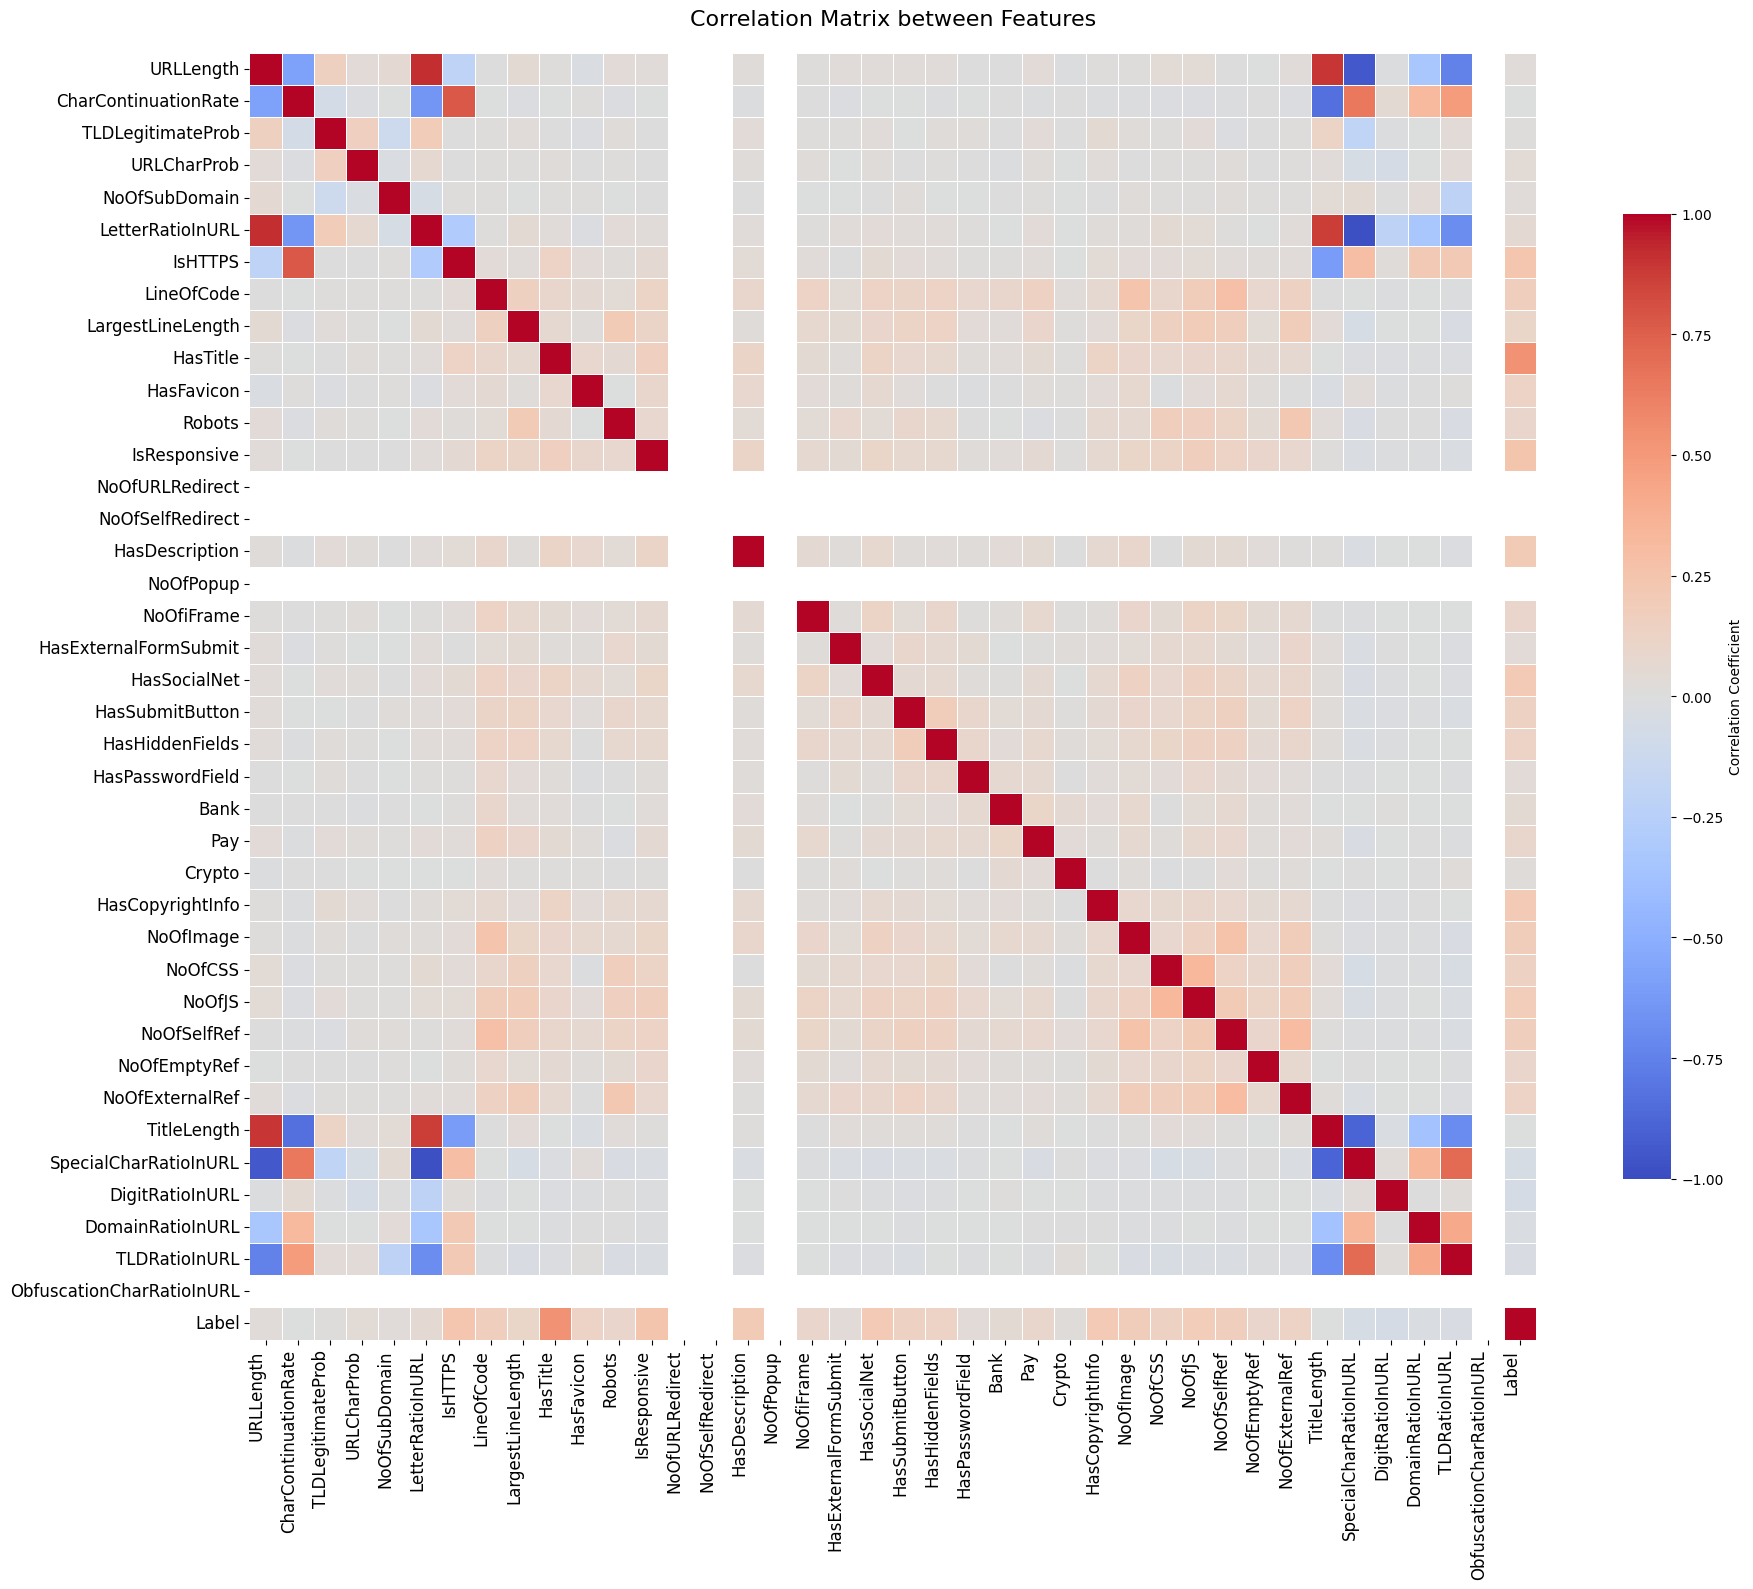

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Correlations Between Features
correlation_matrix = train_set.corr()

print("1. Correlation Matrix between Features:")
print(correlation_matrix)
print()

# Correlation heatmap
plt.figure(figsize=(20, 16))  # Increase the figure size to accommodate longer feature names
sns.heatmap(correlation_matrix,
            annot=False,
            cmap='coolwarm',
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'shrink': 0.75, 'label': 'Correlation Coefficient'},
            square=True,
            annot_kws={'size': 8},
            vmin=-1, vmax=1)

plt.xticks(rotation=90, ha='right', fontsize=12)  # Adjust font size and rotation for x-axis labels
plt.yticks(rotation=0, ha='right', fontsize=12)   # Adjust font size and rotation for y-axis labels
plt.title('Correlation Matrix between Features', fontsize=16, pad=20)

plt.tight_layout()
plt.show()
plt.close()

# Key Insight: The correlation matrix reveals relationships between features that can guide feature selection
# and engineering. Strong correlations (both positive and negative) may indicate redundant features that
# could be combined or eliminated. Features with weak correlations to others may provide unique information.
# The heatmap visualization makes it easy to identify patterns and clusters of related features.
# This analysis is crucial for understanding feature interactions and potential multicollinearity issues.

In [140]:
# Create the pipeline
pipe3 = Pipeline([
    ("scaler", FeatureScaler(NUM_FEATS))
])

# Fit and transform the training set
train_set = pipe3.fit_transform(train_set)
val_set = pipe3.transform(val_set)

C:\Users\Bryan Hutagalung\AppData\Roaming\Python\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [141]:
# Create the pipeline
pipe4 = Pipeline([
    ("encoder", FeatureEncoder(CAT_FEATS))
])

# Fit and transform the training set
train_set = pipe3.fit_transform(train_set)
val_set = pipe3.transform(val_set)

C:\Users\Bryan Hutagalung\AppData\Roaming\Python\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


or create your own here

In [142]:
def match_columns(train, test):
    # Get list of columns in training set
    train_cols = train.columns.tolist()
    
    # Get list of columns in test set
    test_cols = test.columns.tolist()
    
    # Remove any columns in test set that aren't in training set
    for col in test_cols:
        if col not in train_cols:
            test = test.drop(col, axis=1)
    
    # Add any missing columns to test set and fill with 0
    for col in train_cols:
        if col not in test_cols:
            test[col] = 0
    
    # Reorder columns in test set to match training set
    test = test[train_cols]
    
    # Return modified test set
    return test

In [143]:
val_set = match_columns(train_set, val_set)

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `label`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [145]:
# Split column target and features
y_train_set = train_set[TARGET]
X_train_set = train_set.drop(columns=[TARGET], axis=1)

y_val_set = val_set[TARGET]
X_val_set = val_set.drop(columns=[TARGET], axis=1)

X_train_set, X_val_set = merge_and_cluster(X_train_set, X_val_set, n_clusters=9, random_state=42)

In [146]:
X_val_set.shape, y_val_set.shape

((42122, 40), (42122,))

## A. KNN

In [147]:
from lib.KNN import KNN

from sklearn.neighbors import KNeighborsClassifier

knn_scratch = KNN(k=3, n_jobs=-1, p=2, verbose=False)
knn_library = KNeighborsClassifier(n_neighbors=3)

In [148]:
train_set.head()

,URLLength,CharContinuationRate,TLDLegitimateProb,URLCharProb,NoOfSubDomain,LetterRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,TitleLength,SpecialCharRatioInURL,DigitRatioInURL,DomainRatioInURL,TLDRatioInURL,ObfuscationCharRatioInURL,Label
22009,1.618708,0.208733,-1.224531,9.518357e-16,-0.114058,1.350512,1,6.028829e-19,9.043244e-18,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-8.956499e-01,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.340284e+00,3.193943e+00,3.103351e+00,-2.522948e-01,6.694677e-01,3.912981e-01,22,0.147059,0.0,0.588235,0.088235,0.0,1
35264,2.381221,-0.489532,1.095965,9.518357e-16,-0.114058,1.756000,1,6.028829e-19,1.470788e+00,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,4.018156e+00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-7.721513e-01,-2.043963e-18,-7.837478e-17,6.332816e-17,3.451505e-17,8.978604e-01,25,0.135135,0.0,0.540541,0.081081,0.0,1
22328,-0.923001,0.548286,1.095965,9.518357e-16,-0.114058,-0.733244,1,6.028829e-19,9.043244e-18,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-2.351243e-17,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-8.984031e-01,-8.638215e-01,-1.110064e+00,6.332816e-17,-4.179715e-02,1.038572e+00,12,0.208333,0.0,0.666667,0.125000,0.0,1
42031,0.347853,-1.230004,-1.614020,9.357639e-01,-0.114058,0.488268,0,6.028829e-19,1.470788e+00,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.069873e+00,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,6.631712e-17,3.870237e+00,2.401115e+00,-1.425815e+00,3.451505e-17,-2.351243e-17,22,0.172414,0.0,0.689655,0.068966,0.0,1
111621,1.618708,-0.342150,1.095965,-8.179338e-01,-0.114058,1.350512,1,-1.300941e+00,-1.220438e+00,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-8.956499e-01,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-5.827737e-01,-2.043963e-18,-7.837478e-17,-1.048612e+00,3.451505e-17,-8.188231e-01,22,0.147059,0.0,0.764706,0.088235,0.0,1


## B. Naive Bayes

In [149]:
from lib.GNB import GNB
from sklearn.naive_bayes import GaussianNB

gnb_scratch = GNB()
gnb_library = GaussianNB()

In [150]:
# Ensure indices of X_train_set and y_train_set match
X_train_set, y_train_set = X_train_set.align(y_train_set, axis=0, join='inner')

# Fit the classifiers
clfs = [knn_scratch, gnb_scratch, knn_library, gnb_library]

for clf in clfs:
    clf.fit(X_train_set, y_train_set)

## C. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

In [151]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score'],
                          columns = [model_name])

    result = (result * 100).round(5).astype(str) + '%'
    return result

In [152]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name=None):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''

    if model_name is None:
        model_name = clf.__class__.__name__

    # Set font scale
    sns.set(font_scale=1.5)

    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print()
    print(f"\n\t\t {model_name} EVALUATION REPORT")
    print("="*55)
    print("\n\t\t Training Set Performance")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t\t Validation Set Performance")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))

    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 4.2)
    table.set_fontsize(12)
    ax1.axis('tight')
    # Hide the axes
    ax1.axis('off')
    # set the title
    ax1.set_title('{} Performance Summary'.format(model_name), fontsize=18)
    # Modify color
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color(THEME)

    # Plot confusion matrix for test set
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap=CMAP_COLOUR, ax=ax2)
    ax2.set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()



		 KNN EVALUATION REPORT

		 Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.06      0.10       543
           1       0.97      1.00      0.98     15268

    accuracy                           0.97     15811
   macro avg       0.83      0.53      0.54     15811
weighted avg       0.96      0.97      0.95     15811


		 Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.06      0.00      0.00      3204
           1       0.92      1.00      0.96     38918

    accuracy                           0.92     42122
   macro avg       0.49      0.50      0.48     42122
weighted avg       0.86      0.92      0.89     42122





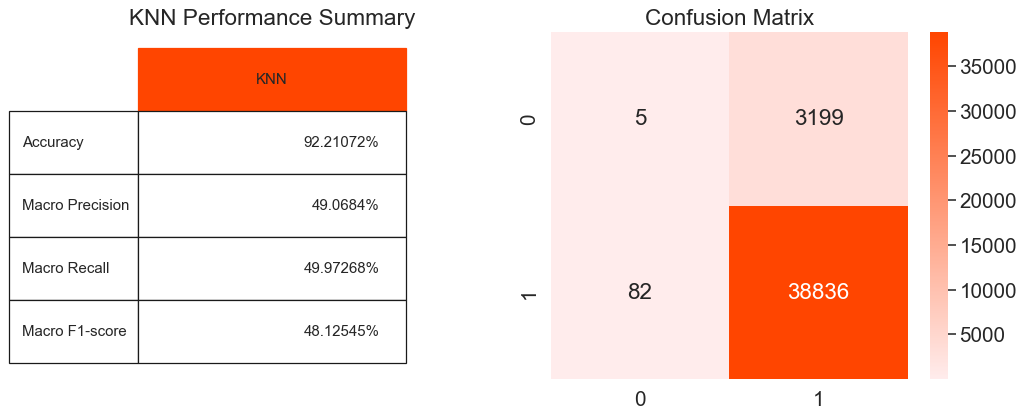

c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = self.means[label][i]
c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variance = self.variances[label][i]
c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:52: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(self._gaussian_density(feature, mean, variance))




		 GNB EVALUATION REPORT

		 Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.03      0.98      0.07       543
           1       0.98      0.03      0.05     15268

    accuracy                           0.06     15811
   macro avg       0.50      0.50      0.06     15811
weighted avg       0.94      0.06      0.05     15811



c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = self.means[label][i]
c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variance = self.variances[label][i]
c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:52: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(self._gaussian_density(feature, mean, variance))



		 Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.06      0.60      0.11      3204
           1       0.89      0.25      0.39     38918

    accuracy                           0.28     42122
   macro avg       0.47      0.43      0.25     42122
weighted avg       0.82      0.28      0.37     42122





c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = self.means[label][i]
c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variance = self.variances[label][i]
c:\Users\Bryan Hutagalung\Documents\Kuliah\sem5\dai\Tubes\IF3070_TB2_K03_G07\src\lib\GNB.py:52: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(self._gaussian_density(feature, mean, variance))


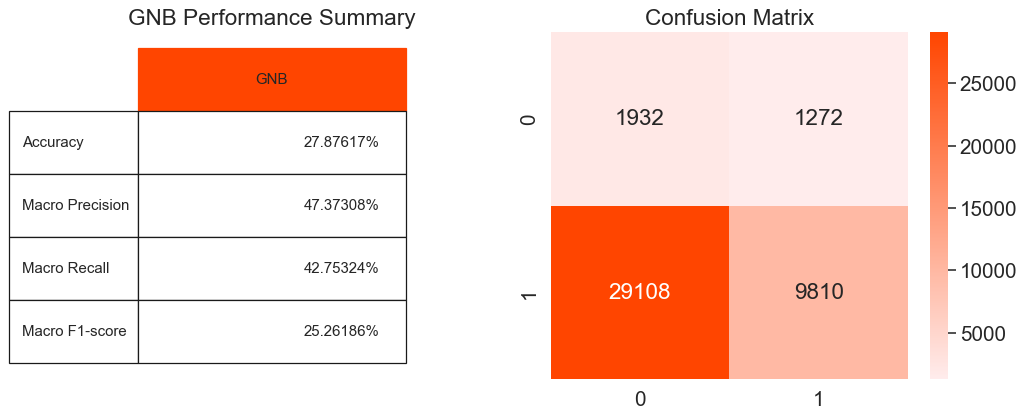



		 KNeighborsClassifier EVALUATION REPORT

		 Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.06      0.10       543
           1       0.97      1.00      0.98     15268

    accuracy                           0.97     15811
   macro avg       0.83      0.53      0.54     15811
weighted avg       0.96      0.97      0.95     15811


		 Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.06      0.00      0.00      3204
           1       0.92      1.00      0.96     38918

    accuracy                           0.92     42122
   macro avg       0.49      0.50      0.48     42122
weighted avg       0.86      0.92      0.89     42122





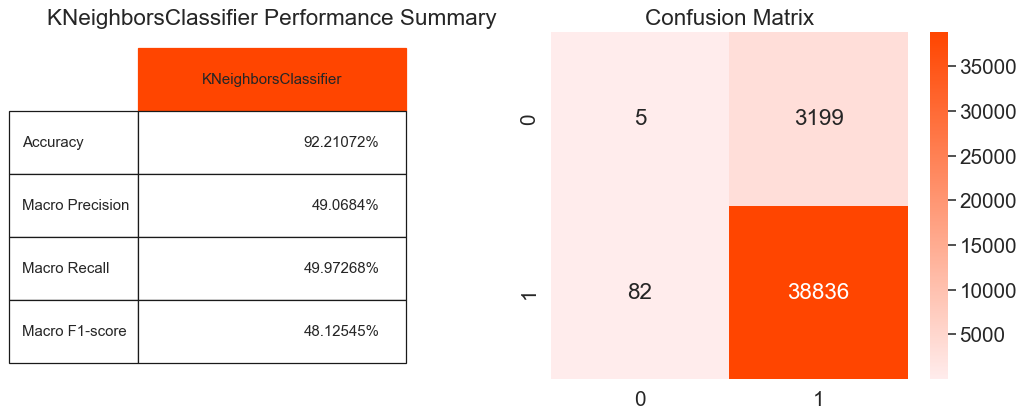



		 GaussianNB EVALUATION REPORT

		 Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.04      0.76      0.07       543
           1       0.97      0.33      0.50     15268

    accuracy                           0.35     15811
   macro avg       0.51      0.54      0.28     15811
weighted avg       0.94      0.35      0.48     15811


		 Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.05      0.39      0.09      3204
           1       0.89      0.41      0.56     38918

    accuracy                           0.41     42122
   macro avg       0.47      0.40      0.33     42122
weighted avg       0.83      0.41      0.53     42122





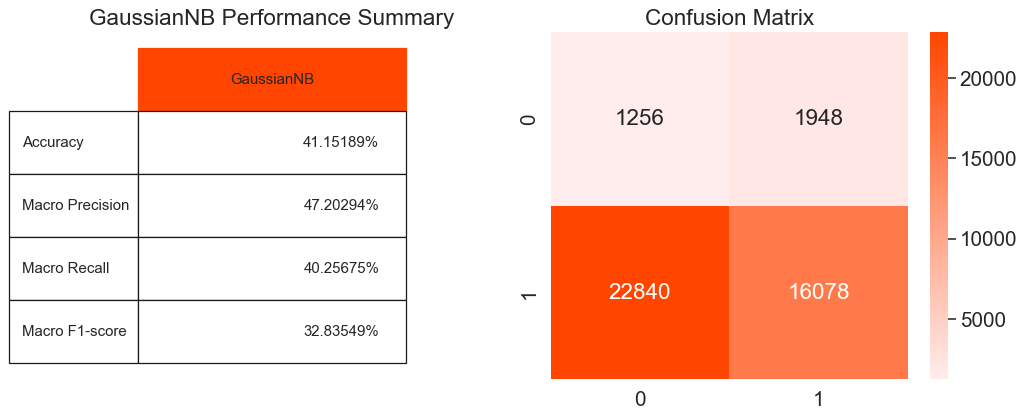

In [153]:
for clf in clfs:
    model_evaluation(clf, X_train_set, X_val_set, y_train_set, y_val_set)

## D. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `label` column.

Note: Adjust step 1 and 2 to your implementation of the preprocessing step if you don't use pipeline API from `sklearn`.

In [154]:
# Type your code here

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

`Provide your analysis here`